Preparando pacotes para o notebook:

In [206]:
# Install packages via Jupyter kernel
%pip install numpy seaborn scipy sklearn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, wilcoxon
from sklearn.datasets import load_digits, load_breast_cancer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Primeira etapa: classificação com ZeroR e Naive Bayes Gaussiano

In [207]:
# Load digits dataset from scikit-learn; split into data and target/label
data, labels = load_digits(return_X_y=True)
# Get the number of samples (lines) and features (columns); also get the number of unique labels, i.e. the number of classes
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size
print(f"- digits: {n_digits}; - samples: {n_samples}; - features: {n_features}")

# Initialize a dummy classifier (zeroR), and the Naive Bayes classifier (GaussianNB)
zR = DummyClassifier(strategy='most_frequent')
NBG = GaussianNB()

# Initialize a scalar pipeline to scale the data before feeding it to the classifier
scalar = StandardScaler()

pipeline_zR = Pipeline([('transformer', scalar), ('estimator', zR)])
pipeline_NBG = Pipeline([('transformer', scalar), ('estimator', NBG)])

# Initialize a stratified k-fold cross-validation object with seed provided by the professor
RSKF = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=36851234)

# Use zeroR (DummyClassifier) and naiveBayes to predict the class of the data with stratified cross-validation (10-fold), repeated 3 times
scores_zR = cross_val_score(pipeline_zR, data, labels, scoring='accuracy', cv=RSKF)
scores_NBG = cross_val_score(pipeline_NBG, data, labels, scoring='accuracy', cv=RSKF)

# Create a dataframe where the columns are the methods and the rows are the scores
df_scores = pd.DataFrame(data={'zR': scores_zR, 'NBG': scores_NBG})
# print(df_scores)

# Calculate statistics for the classifiers
# zR                          
mean_zR = scores_zR.mean()
std_zR = scores_zR.std()
lower_zR, upper_zR = stats.norm.interval(0.95, loc=mean_zR, 
                               scale=std_zR/np.sqrt(len(scores_zR)))
                               
# NBG
mean_NBG = scores_NBG.mean()
std_NBG = scores_NBG.std()
lower_NBG, upper_NBG = stats.norm.interval(0.95, loc=mean_NBG, scale=std_NBG/np.sqrt(len(scores_NBG)))
     

- digits: 10; - samples: 1797; - features: 64


Definição do KMC:

In [208]:
from sklearn.base import BaseEstimator
from sklearn.utils import check_X_y
from sklearn.cluster import KMeans

# The KMC classifier uses a clustering algorithm to define K groups of examples of each class in the training base.
class KMeansCentroidsClassifier(BaseEstimator):
    def __init__(self, k=1):
        super().__init__()
        self.k = k
        self.centroids = []

    # Fit KMC centroids to the training base
    def fit(self, x_train, y_train):
        x_train, y_train = check_X_y(x_train, y_train)

        # Create k groups for each class
        for _class in np.unique(y_train):
            # Initialize KMeans:
            km = KMeans(n_clusters=self.k)
            # Fit KMeans:
            km.fit(x_train[y_train == _class], y_train[y_train == _class])
            # Append centroids to centroids list:   
            self.centroids.append({"clusters": km.cluster_centers_, "class": _class})

    # Find the closest centroid and return its class
    def predict(self, x_test):
        classes = []
        for x in x_test:
            min_dist = np.Inf
            
            for centroid in self.centroids:
                for cluster in centroid["clusters"]:
                    dist = np.linalg.norm(x - cluster)
                    if dist < min_dist:
                        min_dist = dist
                        _class = centroid["class"]

            classes.append(_class)
            
        return classes

Preparando os modelos para a classificação:

In [209]:
dKNN = KNeighborsClassifier(weights='distance')
pipeline_kNN = Pipeline([('transformer', scalar), ('estimator', dKNN)])
KMC = KMeansCentroidsClassifier()
pipeline_KMC = Pipeline([('transformer', scalar), ('estimator', KMC)])
AD = DecisionTreeClassifier()
pipeline_AD = Pipeline([('transformer', scalar), ('estimator', AD)])

# "Neste caso, o procedimento de treinamento, validação e teste será realizado através de 3 rodadas de ciclos aninhados de validação e teste,
# com o ciclo interno de validação contendo 4 folds e o externo de teste com 10 folds."
RSKF = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

# "A busca em grade (grid search) do ciclo interno deve considerar os seguintes valores de hiperparâmetros de cada técnica de aprendizado:
# KMC: [k = 1, 3, 5, 7]
# KNN: [n_neighbors = 1, 3, 5, 7]
# AD: [max_depth = None, 3, 5, 10]"
grade_kNN = {'estimator__n_neighbors': [1, 3, 5, 7]}
grade_KMC = {'estimator__k': [1, 3, 5, 7]}
grade_AD = {'estimator__max_depth': [None, 3, 5, 10]}
grid_search_kNN = GridSearchCV(estimator=pipeline_kNN, param_grid=grade_kNN, scoring='accuracy', cv=4)
grid_search_KMC = GridSearchCV(estimator=pipeline_KMC, param_grid=grade_KMC, scoring='accuracy', cv=4)
grid_search_AD = GridSearchCV(estimator=pipeline_AD, param_grid=grade_AD, scoring='accuracy', cv=4)

scores_kNN = cross_val_score(grid_search_kNN, data, labels, scoring='accuracy', cv=RSKF)
scores_KMC = cross_val_score(grid_search_KMC, data, labels, scoring='accuracy', cv=RSKF)
scores_AD = cross_val_score(grid_search_AD, data, labels, scoring='accuracy', cv=RSKF)

mean_kNN = scores_kNN.mean()
std_kNN = scores_kNN.std()
lower_kNN, upper_kNN = stats.norm.interval(0.95, loc=mean_kNN, scale=std_kNN/np.sqrt(len(scores_kNN)))

mean_KMC = scores_KMC.mean()
std_KMC = scores_KMC.std()
lower_KMC, upper_KMC = stats.norm.interval(0.95, loc=mean_KMC, scale=std_KMC/np.sqrt(len(scores_KMC)))

mean_AD = scores_AD.mean()
std_AD = scores_AD.std()
lower_AD, upper_AD = stats.norm.interval(0.95, loc=mean_AD, scale=std_AD/np.sqrt(len(scores_AD)))

Funções auxiliares para gerar tabelas dos resultados dos experimentos

In [210]:
# Test a pair of scores against each other
def test_two_models(scores1, scores2):
    pTValue = ttest_rel(scores1, scores2)
    pWValue = wilcoxon(scores1, scores2)
    return pTValue, pWValue

# Test all models against each other
def test_models(all_scores):
    # Test each model with the other, one by one:
    pTValues = []
    pWValues = []

    testsDict = {}
    for i, (model, score) in enumerate(all_scores.items()):
        testsDict[model] = []
        for j in range(i+1, len(all_scores)):
            pTValue, pWValue = test_two_models(score, all_scores[list(all_scores.keys())[j]])
            testsDict[model].append({'p': pTValue.pvalue, 'w': pWValue.pvalue})

    return testsDict

# Create a matrix of all models vs all models
def get_statistical_tests_matrix(statisticalTestsDict):
    MIN_CONFIDENCE_LEVEL = 0.05
    statisticalTestMatrix = [[None for _ in range(len(statisticalTestsDict))] for _ in range(len(statisticalTestsDict))]
    
    print("Statistical tests:")
    
    # Iterate over statisticalTestsDict in a cross fashion:
    for i, (model, tests) in enumerate(statisticalTestsDict.items()):
        # Print model name in the diagonal:
        j = i
        statisticalTestMatrix[i][j] = model
        for test in tests:
            j += 1
            statisticalTestMatrix[i][j] = round(test['p'], 8)
            statisticalTestMatrix[j][i] = round(test['w'], 8)
                
    return statisticalTestMatrix

# Create a LaTeX table of all models vs all models
def create_matrix_table(statisticalTestMatrix):
    print("\hline")
    for row in statisticalTestMatrix:
        for i, cell in enumerate(row):
            ending = None
            # If cell is not the last in the row:
            if i != len(row) - 1:
                ending = ' & '
            else: 
                ending = ' \\\\ \hline\n'
                
            if type(cell) is not str:
                if cell > 0.05:
                    print(cell, end=ending)
                else:
                    print(f'\\textbf{{{cell}}}', end=ending)
            else: 
                print(cell, end=ending)


# Create a header for the LaTeX stats table
def create_stats_header():
    return '\\textbf{Método} & \\textbf{Média} & \\textbf{Desvio Padrão} & \\textbf{Limite Inferior} & \\textbf{Limite Superior} \\ \hline \n'

# Create a line for the LaTeX stats table
def create_stats_table_line(method_name, mean, std, lower, upper):
    return '{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\ \hline \n'.format(method_name, mean, std, lower, upper)

Statistical tests:
\hline
zR & \textbf{0.0} & \textbf{0.0} & \textbf{0.0} & \textbf{0.0} \\ \hline
\textbf{1.71e-06} & NBG & \textbf{0.0} & \textbf{0.0} & \textbf{0.0} \\ \hline
\textbf{1.66e-06} & \textbf{1.72e-06} & kNN & \textbf{0.0} & \textbf{2.1e-07} \\ \hline
\textbf{1.71e-06} & \textbf{2.87e-06} & \textbf{1.73e-06} & AD & \textbf{0.0} \\ \hline
\textbf{1.7e-06} & \textbf{1.73e-06} & \textbf{1.1e-05} & \textbf{1.73e-06} & KMC \\ \hline
[['zR', 0.0, 0.0, 0.0, 0.0], [1.71e-06, 'NBG', 0.0, 0.0, 0.0], [1.66e-06, 1.72e-06, 'kNN', 0.0, 2.1e-07], [1.71e-06, 2.87e-06, 1.73e-06, 'AD', 0.0], [1.7e-06, 1.73e-06, 1.1e-05, 1.73e-06, 'KMC']]
\textbf{Método} & \textbf{Média} & \textbf{Desvio Padrão} & \textbf{Limite Inferior} & \textbf{Limite Superior} \ \hline 
ZR & 0.10 & 0.00 & 0.10 & 0.10 \\ \hline 
NGB & 0.78 & 0.03 & 0.77 & 0.80 \\ \hline 
KMC & 0.95 & 0.02 & 0.95 & 0.96 \\ \hline 
KNN & 0.98 & 0.01 & 0.97 & 0.98 \\ \hline 
AD & 0.86 & 0.03 & 0.85 & 0.87 \\ \hline 



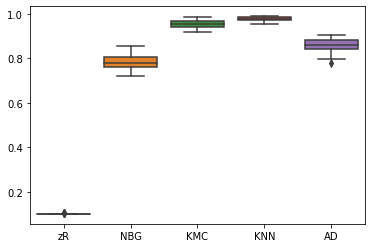

In [211]:
scoresDict = {
    'zR': scores_zR,
    'NBG': scores_NBG,
    'kNN': scores_kNN,
    'AD': scores_AD,
    'KMC': scores_KMC,
}

statisticalTestsDict = test_models(scoresDict)

# Create the statistical tests results. The diagonal of the matrix contains the names of the models. The upper diagonal contains the p-values of the statistical tests. The lower diagonal contains the Wilcoxon p-values.
statisticalTestMatrix = get_statistical_tests_matrix(statisticalTestsDict)
create_matrix_table(statisticalTestMatrix)

# Add KNN, AD and KMC scores to df_scores:
df_scores['KMC'] = scores_KMC
df_scores['KNN'] = scores_kNN
df_scores['AD'] = scores_AD

table = create_stats_header()
table += create_stats_table_line('ZR', mean_zR, std_zR, lower_zR, upper_zR)
table += create_stats_table_line('NGB', mean_NBG, std_NBG, lower_NBG, upper_NBG)
table += create_stats_table_line('KMC', mean_KMC, std_KMC, lower_KMC, upper_KMC)
table += create_stats_table_line('KNN', mean_kNN, std_kNN, lower_kNN, upper_kNN)
table += create_stats_table_line('AD', mean_AD, std_AD, lower_AD, upper_AD)

print(statisticalTestMatrix)
print(table)

# Draw boxplot of all scores
sns.boxplot(data=df_scores)
plt.show()
